In [1]:
# importing libraries

# for language detection
from langdetect import detect

# for language translation
from googletrans import Translator

# to get counts and most common elements
from collections import Counter

# for visualization
import matplotlib.pyplot as plt

# to get wordcloud
from wordcloud import WordCloud

# to fetch ngrams
from nltk.util import ngrams

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# for data analysis and manipulation
import pandas as pd
import numpy as np

# to expand the text (don't to do not)
import contractions

# to auto correct the words
from autocorrect import Speller

# for handling accented characters (Á to A)
from unidecode import unidecode

# to get list of punctuations
from string import punctuation

# nltk libraries 
from nltk.tokenize import word_tokenize # to make tokens (sentense/words)
from nltk.corpus import stopwords # to get list of stopwords
from nltk.stem import WordNetLemmatizer # to find root words

# for extracting the keywords
import yake
from rake_nltk import Rake

# for making vectors of the documents
from gensim.models import Word2Vec, keyedvectors

# to see how the clusters are generated
from yellowbrick.cluster import SilhouetteVisualizer

# scikit_learn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

# to balance the data
from imblearn.over_sampling import SMOTE

# Problem Statement

**The problem was to find whether the customers are happy with the product.**

# Data Gathering

In [2]:
df = pd.read_csv("Amazon_rev.csv",index_col="Unnamed: 0")
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


### Initial Preprocessing

In [3]:
# taking only relevent features
df1 = df[["Summary","Text","Score"]]
df1.head(3)

,Summary,Text,Score
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,"""Delight"" says it all",This is a confection that has been around a fe...,positive


In [4]:
# checking for duplicate rows
df1.duplicated().sum()

160677

In [5]:
# droping the duplicate rows
df1.drop_duplicates(inplace=True)

In [6]:
# As I am working on the local machine So I am taking only 10000 samples
a = df1.sample(10000)
df1 = a.copy()

In [9]:
# Checking the language of the text
def lang_dect(data):
    lang = detect(data)
    return lang
s = pd.Series(df1["Text"].apply(lang_dect))
s.unique()

array(['en', 'af', 'es', 'de'], dtype=object)

**Here we can see that we have reviews in different languages. So I supposed to translate them.**

*en: english, es: Spanish, af: Afrikaans, de: German*


In [10]:
# defining the function for translating all reviews into english
def lang_translate(data):
    translor = Translator()
    tr_text = translor.translate(data,dest="en")
    return tr_text.text

In [13]:
# translating the reviews
df1["reviews"] = df1["Text"].apply(lang_translate)
df1.reset_index(drop = True,inplace=True)
df1.head()

In [15]:
# As the translator takes high time to translate the reviews So I am saving translated reviews in csv file for further use
df1.to_csv("translateddata10000.csv",index = False)

In [16]:
# as we translate the reviews so we will remove the Text feature
df1.drop("Text",axis = 1, inplace = True)

In [17]:
df1.head()

,Summary,Score,reviews
0,"Yucky Tasting and High in Sugar, Carbs and Cal...",negative,"I prefer Monster or Rockstar energy drinks, bu..."
1,Very Pleasantly Surprised,positive,I usually only like Crystal Light lemonade bec...
2,love stubb's flavor,positive,I love this product. Found it first at my loc...
3,YAY! cost the same as regular oatmeal but it's...,positive,It taste a little less like sugar and more lik...
4,Always fresh and delicious,positive,These jelly beans are perfect for my automatic...


# EDA

<AxesSubplot:>

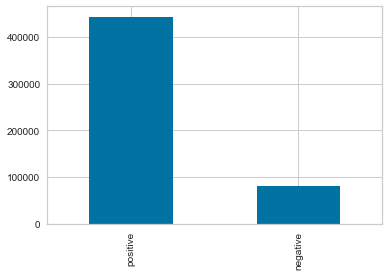

In [21]:
a = df.Score.value_counts()
a.plot(kind = "bar")

**the data is highly imbalanced. So, I supposed to balance this data**

In [22]:
# ngrams 
def splitting_text(data):
    tokens = data.split()
    return tokens

def ngram_extract(data,ngram_range):
    tokens = splitting_text(data)
    ngram = ngrams(tokens,ngram_range)
    ngram_lst = []
    for i in ngram:
        ngram_lst.append(" ".join(i))
    return ngram_lst

In [23]:
unigram = df1["reviews"].apply(lambda x: ngram_extract(x,1))
unigram

0       [I, prefer, Monster, or, Rockstar, energy, dri...
1       [I, usually, only, like, Crystal, Light, lemon...
2       [I, love, this, product., Found, it, first, at...
3       [It, taste, a, little, less, like, sugar, and,...
4       [These, jelly, beans, are, perfect, for, my, a...
                              ...                        
9995    [WellI, have, been, using, this, for, quite, a...
9996    [These, winegums, have, a, good, flavor., Like...
9997    [Tried, this, when, it, went, on, sale, for, $...
9998    [All, around, good, product., Coffee, is, tast...
9999    [We, got, hooked, on, these, after, having, th...
Name: reviews, Length: 10000, dtype: object

In [24]:
# cheking the most frequent unigrams
final_unigrams = []
for i in unigram:
    final_unigrams.extend(i)
Counter(final_unigrams).most_common(25)

[('the', 28483),
 ('I', 24604),
 ('and', 22171),
 ('a', 20571),
 ('to', 17527),
 ('of', 13966),
 ('is', 12763),
 ('it', 11239),
 ('in', 9394),
 ('for', 9280),
 ('this', 8713),
 ('that', 6995),
 ('my', 6330),
 ('with', 6154),
 ('have', 5969),
 ('was', 5552),
 ('but', 5470),
 ('are', 5295),
 ('you', 5005),
 ('not', 4859),
 ('on', 4723),
 ('/><br', 4546),
 ('as', 4390),
 ('like', 4027),
 ('so', 3635)]

In [25]:
bigram = df1["reviews"].apply(lambda x: ngram_extract(x,2))
# cheking the most frequent bigrams
final_bigrams = []
for i in bigram:
    final_bigrams.extend(i)
Counter(final_bigrams).most_common(25)

[('of the', 2593),
 ('in the', 2234),
 ('I have', 2086),
 ('is a', 1606),
 ('I was', 1388),
 ('and I', 1340),
 ('it is', 1277),
 ('on the', 1238),
 ('for a', 1213),
 ('and the', 1139),
 ('I am', 1110),
 ('This is', 1068),
 ('is the', 1048),
 ('to the', 1035),
 ('in a', 1017),
 ('for the', 961),
 ('to be', 939),
 ('a little', 933),
 ('this is', 911),
 ('with the', 871),
 ('I love', 824),
 ('it was', 821),
 ('they are', 800),
 ('and it', 796),
 ('a great', 795)]

In [26]:
trigram = df1["reviews"].apply(lambda x: ngram_extract(x,3))
# cheking the most frequent trigrams
final_trigrams = []
for i in trigram:
    final_trigrams.extend(i)
Counter(final_trigrams).most_common(25)

[('a lot of', 303),
 ('This is a', 294),
 ('is the best', 242),
 ('is a great', 239),
 ('one of the', 235),
 ('I have been', 231),
 ('This is the', 217),
 ('this is a', 202),
 ('out of the', 192),
 ('I love this', 166),
 ('this is the', 165),
 ('I have tried', 163),
 ('it is a', 162),
 ('and it is', 160),
 ('I had to', 158),
 ('I love the', 156),
 ('I bought this', 154),
 ('it in the', 152),
 ('some of the', 150),
 ('a bit of', 145),
 ('a couple of', 143),
 ('I have to', 142),
 ('I have a', 139),
 ('and this is', 135),
 ('I decided to', 133)]

##### So we can see that most of the reviews are positive

### word cloud

In [27]:
# defining the function to plot a word cloud
def word_cloud(data,column):
    df_ = data[column].str.cat(sep = " ")
    text = " ".join([i for i in df_.split()])
    wcloud = WordCloud(width = 700,height = 500, background_color= "linen").generate(text)
    plt.figure(figsize = (15,10))
    plt.imshow(wcloud)
    plt.axis("off")
    plt.show()

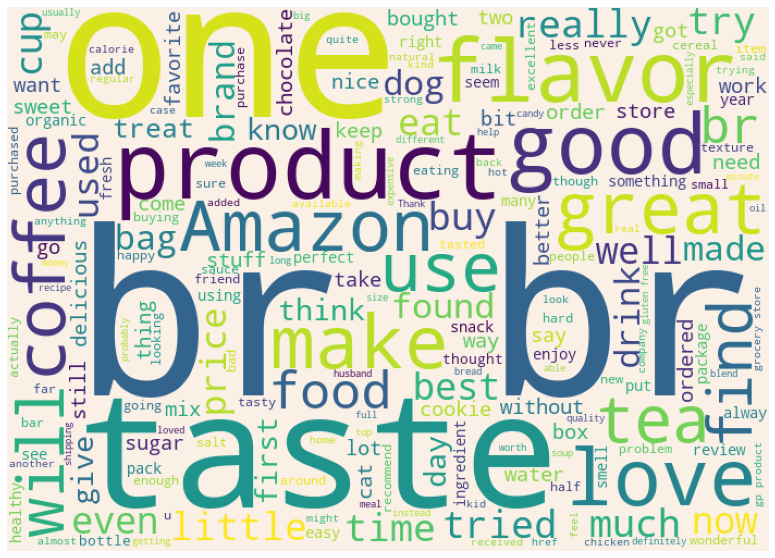

In [28]:
word_cloud(df1,"reviews")

###### here we can see the mostly reviews are good 

### Key phrase extrection

In [29]:
# Defining the function to extract keywords
def yake_extractor(data):
    key_ext = yake.KeywordExtractor()
    keywords = key_ext.extract_keywords(data) # give (kewword, score) in a tuple
    key_lst = []
    for i in keywords:
        key_lst.append(i[0])
    return key_lst

In [30]:
keywords = df1["reviews"].apply(yake_extractor)
all_kw = []
for i in keywords:
    all_kw.extend(i)
cnt = Counter(all_kw).most_common(100)
cnt

[('good', 1226),
 ('product', 1171),
 ('great', 1134),
 ('taste', 1023),
 ('love', 964),
 ('flavor', 864),
 ('Amazon', 772),
 ('coffee', 766),
 ('tea', 630),
 ('time', 542),
 ('food', 509),
 ('price', 502),
 ('find', 495),
 ('buy', 455),
 ('bought', 439),
 ('make', 411),
 ('eat', 405),
 ('delicious', 351),
 ('dog', 341),
 ('years', 326),
 ('chocolate', 324),
 ('favorite', 320),
 ('store', 310),
 ('ordered', 298),
 ('box', 297),
 ('loves', 294),
 ('found', 290),
 ('sweet', 290),
 ('bag', 283),
 ('sugar', 271),
 ('drink', 270),
 ('tastes', 269),
 ('Great', 266),
 ('made', 262),
 ('order', 259),
 ('water', 259),
 ('day', 253),
 ('stuff', 251),
 ('perfect', 235),
 ('nice', 229),
 ('mix', 227),
 ('snack', 223),
 ('tasty', 210),
 ('free', 210),
 ('purchased', 207),
 ('flavors', 204),
 ('hot', 204),
 ('products', 203),
 ('local', 202),
 ('stores', 202),
 ('hard', 199),
 ('brand', 199),
 ('fresh', 197),
 ('dogs', 196),
 ('healthy', 195),
 ('cup', 193),
 ('quality', 192),
 ('recommend', 192),
 

In [31]:
# defining the function to extract rake keywords
def rake_extract(data):
    k_extr = Rake()
    k_extr.extract_keywords_from_text(data)
    return k_extr.get_ranked_phrases()

In [32]:
keyword1 = df1["reviews"].apply(rake_extract)
all_kw1 = []
for i in keyword1:
    all_kw1.extend(i)
cnt = Counter(all_kw1).most_common(100)
cnt

[('product', 1886),
 ('like', 1599),
 ('amazon', 1412),
 ('love', 1389),
 ('one', 1239),
 ('good', 1154),
 ('taste', 1147),
 ('get', 1118),
 ('use', 1028),
 ('find', 986),
 ('flavor', 919),
 ('try', 896),
 ('buy', 867),
 ('coffee', 846),
 ('great', 822),
 ('make', 806),
 ('tried', 801),
 ('found', 744),
 ('well', 716),
 ('tea', 713),
 ('time', 706),
 ('used', 686),
 ('much', 676),
 ('eat', 670),
 ('think', 657),
 ('price', 656),
 ('bought', 638),
 ('know', 633),
 ('would', 610),
 ('made', 560),
 ('food', 541),
 ('want', 513),
 ('give', 506),
 ('order', 485),
 ('lot', 483),
 ('best', 470),
 ('also', 461),
 ('com', 455),
 ('easy', 445),
 ('got', 442),
 ('even', 442),
 ('need', 439),
 ('box', 427),
 ('way', 426),
 ('delicious', 424),
 ('go', 422),
 ('thought', 420),
 ('ordered', 420),
 ('however', 412),
 ('see', 409),
 ('water', 406),
 ('far', 398),
 ('put', 398),
 ('day', 396),
 ('keep', 388),
 ('say', 386),
 ('add', 382),
 ('drink', 375),
 ('bag', 372),
 ('sweet', 372),
 ('stuff', 363),

###### by seeing form both of the keyword extractors most of the reviews are looking positive

# Preprocessing
### Data Cleaning

In [33]:
# defining the function for removing spaces
def remove_spaces(data):
    clean_text = data.replace("\\n"," ").replace("\t"," ").replace("\\"," ")
    return clean_text

# defining the function for expanding text (can't to can not)
def expand_text(data):
    ex_text = contractions.fix(data)
    return ex_text

# defining the function for handling accented characters (Á to A)
def handling_accented(data):
    fix_text = unidecode(data)
    return fix_text

# defining the function for removing stopwords
stopword = stopwords.words("english") # gives a list of stopwords
stopword.remove("no") # removing neccessary stop words from list
stopword.remove("not")
stopword.remove("nor")

def clean_text(data):
    token = word_tokenize(data)
    clean_text = [i.lower() for i in token if (i not in punctuation) 
                  and (i.lower() not in stopword) and (i.isalpha()) and (len(i) > 2)]
    return clean_text

# defining the function for auto correction 
def auto_correct(data):
    spell = Speller(lang = "en")
    text = spell(data)
    return text

# defining the function for getting root words
def lemmatization(data):
    lem = WordNetLemmatizer()
    lst1 = []
    for i in data:
        lem_words = lem.lemmatize(i)
        lst1.append(lem_words)
    return " ".join(lst1)

In [34]:
df1["final_rev"] = df1["reviews"].apply(remove_spaces)
df1["final_rev"] = df1["final_rev"].apply(expand_text)
df1["final_rev"] = df1["final_rev"].apply(handling_accented)
df1["final_rev"] = df1["final_rev"].apply(clean_text)
df1["final_rev"] = df1["final_rev"].apply(lambda x: auto_correct(x) if isinstance(x, str) or isinstance(x, bytes) else x)
df1["final_rev"] = df1["final_rev"].apply(lemmatization)

In [36]:
# now we have the final reviews so we will drop the reviews and summary features
df1.drop("reviews", axis = 1,inplace = True)
df1.drop(["Summary"], inplace = True, axis = 1)

In [37]:
# encoding the target feature
df1.Score.replace({"negative": 0, "positive": 1}, inplace=True)

In [39]:
# So, now I have the data for vectorization
df1.head(3)

,Score,final_rev
0,0,prefer monster rockstar energy drink always tr...
1,1,usually like crystal light lemonade flavor art...
2,1,love product found first local bevmo could not...


In [108]:
df1.final_rev.dtype

dtype('O')

### CountVactorizer

In [95]:
# spliting the data to avoid data leakage
x = df1["final_rev"]
y = df1["Score"]
x_tr,x_te,y_tr,y_te = train_test_split(x,y,test_size=0.25,random_state=42,stratify=y)

In [84]:
# Creating the vectors of the reviews
cnv = CountVectorizer(max_df=0.95,max_features=1000,min_df = 10, stop_words="english",lowercase=True)
x_train = cnv.fit_transform(x_tr).A
x_test  = cnv.transform(x_te).A

### balancing the data

In [85]:
# I am using SMOTE to avoid data duplicacy
st = SMOTE(sampling_strategy=0.75,random_state=42)
sm_x_train,sm_y_train = st.fit_resample(x_train,y_tr)
sm_x_test,sm_y_test   = st.fit_resample(x_test,y_te)

# Model Selection & Training

In [86]:
# Training and evaluating MultinomialNB model
mlnb = MultinomialNB()
mlnb.fit(sm_x_train,sm_y_train)

MultinomialNB()

In [87]:
pred = mlnb.predict(sm_x_train)
acc = accuracy_score(sm_y_train,pred)
clf = classification_report(sm_y_train,pred)
print("The accuracy of the model is: ",acc)
print("\n")
print("The classifiaction report:\n",clf)

The accuracy of the model is:  0.8246570364313619


The classifiaction report:
               precision    recall  f1-score   support

           0       0.85      0.72      0.78      4717
           1       0.81      0.91      0.86      6290

    accuracy                           0.82     11007
   macro avg       0.83      0.81      0.82     11007
weighted avg       0.83      0.82      0.82     11007



In [88]:
pred1 = mlnb.predict(sm_x_test)
acc1 = accuracy_score(sm_y_test,pred1)
clf1 = classification_report(sm_y_test,pred1)
print("The accuracy of the model is: ",acc1)
print("\n")
print("The classifiaction report:\n",clf1)

The accuracy of the model is:  0.7644492911668485


The classifiaction report:
               precision    recall  f1-score   support

           0       0.80      0.59      0.68      1572
           1       0.75      0.89      0.81      2096

    accuracy                           0.76      3668
   macro avg       0.78      0.74      0.75      3668
weighted avg       0.77      0.76      0.76      3668



**Here we can see the model has good accuracy but I will check another model**

In [92]:
# Training and evaluating the XG Boost model
xgb = XGBClassifier()
xgb.fit(sm_x_train,sm_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [93]:
pred = xgb.predict(sm_x_train)
acc = accuracy_score(sm_y_train,pred)
clf = classification_report(sm_y_train,pred)
print("The accuracy of the model is: ",acc)
print("\n")
print("The classifiaction report:\n",clf)

The accuracy of the model is:  0.9461251930589625


The classifiaction report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      4717
           1       0.96      0.94      0.95      6290

    accuracy                           0.95     11007
   macro avg       0.94      0.95      0.95     11007
weighted avg       0.95      0.95      0.95     11007



In [96]:
pred1 = xgb.predict(sm_x_test)
acc1 = accuracy_score(sm_y_test,pred1)
clf1 = classification_report(sm_y_test,pred1)
print("The accuracy of the model is: ",acc1)
print("\n")
print("The classifiaction report:\n",clf1)

The accuracy of the model is:  0.88113413304253


The classifiaction report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1572
           1       0.89      0.91      0.90      2096

    accuracy                           0.88      3668
   macro avg       0.88      0.88      0.88      3668
weighted avg       0.88      0.88      0.88      3668



**So here we can see the XG Boost model has good accuracy with good precesion, recall and f1score. So I will go for production with XG Boost model**

**As I was working on local machine so i use only 10000 rows. So, we can achive more accuracy with more data**

### Tuning the model

In [100]:
from sklearn.model_selection import RandomizedSearchCV
estimator = XGBClassifier()
para_grid = {"n_estimators":[100, 250, 500,750, 1000], "min_child_weight": [1, 3, 5, 7],
             "subsample": [0.7,0.8,0.9,1], "learning_rate": [0.1, 0.01, 0.001],
             "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2], "max_depth": [3, 4, 7, 10],
             "colsample_bytree": [0.3, 0.6, 0.8, 1.0], "reg_alpha": [0, 0.5, 1], 
             "reg_lambda": [1, 1.5, 2, 3, 4.5]}
rnd = RandomizedSearchCV(estimator=estimator,param_distributions=para_grid,
                         scoring= "accuracy", cv=3, verbose=3, random_state=40)
#increase the CV to 7 when training on a high powered gpu else it will take high time
rnd.fit(sm_x_train,sm_y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=1.0, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1;, score=0.757 total time=   5.9s
[CV 2/3] END colsample_bytree=1.0, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1;, score=0.882 total time=   5.7s
[CV 3/3] END colsample_bytree=1.0, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1;, score=0.882 total time=   5.7s
[CV 1/3] END colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, reg_alpha=0, reg_lambda=2, subsample=1;, score=0.717 total time=  12.1s
[CV 2/3] END colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, reg_alpha=0, reg_lambda=2, subsample=1;, score=0.832 total time=  12.1s
[

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.3, 0.6, 0.8,
                                                             1.0],
                                        'gamma': [0.01, 0.1, 0.3, 0.5, 1, 1.5,
                                                  2],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': [3, 4, 7, 10],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 250, 500, 750,
                                                         1000],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [1, 1.5, 2, 3, 4.5],
                                        'subsample': [0.7, 0.8, 0.9, 1]},
                   random_state=40, scoring='accuracy', verbose=3)

In [101]:
rnd.best_params_

{'subsample': 1,
 'reg_lambda': 2,
 'reg_alpha': 1,
 'n_estimators': 750,
 'min_child_weight': 1,
 'max_depth': 7,
 'learning_rate': 0.01,
 'gamma': 0.3,
 'colsample_bytree': 0.6}

In [102]:
xgbtuned = XGBClassifier(subsample = 1, reg_lambda= 2, reg_alpha= 1, n_estimators= 750,
                         min_child_weight= 1, max_depth= 7, learning_rate= 0.01,
                         gamma= 0.3, colsample_bytree= 0.6)
xgbtuned.fit(sm_x_train,sm_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=750, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [103]:
pred = xgbtuned.predict(sm_x_train)
acc = accuracy_score(sm_y_train,pred)
clf = classification_report(sm_y_train,pred)
print("The accuracy of the model is: ",acc)
print("\n")
print("The classifiaction report:\n",clf)

The accuracy of the model is:  0.8952484782411193


The classifiaction report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      4717
           1       0.92      0.89      0.91      6290

    accuracy                           0.90     11007
   macro avg       0.89      0.90      0.89     11007
weighted avg       0.90      0.90      0.90     11007



In [104]:
pred1 = xgbtuned.predict(sm_x_test)
acc1 = accuracy_score(sm_y_test,pred1)
clf1 = classification_report(sm_y_test,pred1)
print("The accuracy of the model is: ",acc1)
print("\n")
print("The classifiaction report:\n",clf1)

The accuracy of the model is:  0.8650490730643402


The classifiaction report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84      1572
           1       0.89      0.88      0.88      2096

    accuracy                           0.87      3668
   macro avg       0.86      0.86      0.86      3668
weighted avg       0.87      0.87      0.87      3668



**Now our model has good treadoff between training and testing accuracies, and, precision and recall of both classes. Overall we can say this is the quality model.**

# Model Testing

In [113]:
# testing the model whether it works for userinput.
dics = {1: "Positive" , 0:"Negative" }
#user input
review1 = "I love this product"

# first we create a vector of this review
vector1 = cnv.transform([review1]).A

# getting prediction
prediction = xgbtuned.predict(vector1)

# printing the results
print("The product review is ",dics[prediction[0]])

The product review is  Positive


In [114]:
# testing the model by giving negative review
dics = {1: "Positive" , 0:"Negative" }
#user input
review1 = "I did not like this product"

# first we create a vector of this review
vector1 = cnv.transform([review1]).A

# getting prediction
prediction = xgbtuned.predict(vector1)

# printing the results
print("The product review is ",dics[prediction[0]])

The product review is  Negative


**FINALLY, WE CAN SEE THAT OUR MODEL IS WORKING WELL**

# Exporting the model for production

In [115]:
with open("XGBmodel.pkl","wb") as f:
    pickle.dump(xgbtuned,f)
with open("countvectorizer.pkl","wb") as f:
    pickle.dump(cnv,f)

# *Thank You*